# Simulator-runtime summary

- **JAX on GPU is fastest for realistic problem sizes**  
  * In every case with **N ≥ 80**, running the same JAX code on a GPU is **3 – 9 × faster** than any other backend.  
  * The performance gap widens as the timestep is refined (smaller `dt`) or the simulated time is lengthened.

- **JAX on CPU outperforms the GPU for very small grids**  
  * For **N = 40** the CPU execution is **≈ 2 – 3 × faster** than the GPU execution at all tested `dt` values.  
  * Reason: Each timestep launches a tiny kernel; GPU launch and synchronisation overhead dominates, while the CPU keeps the data in L3 cache.

- **PyTorch occupies the middle ground**  
  * At **N ≥ 80** PyTorch is roughly **2 × faster** than NumPy but remains **2 – 4 × slower** than JAX-GPU.  
  * At **N = 40** the launch overhead brings PyTorch to parity with NumPy.

- **NumPy is consistently the slowest backend**  
  * Wall-clock time scales almost linearly with simulated time for all libraries, but NumPy’s absolute runtimes are one to two orders of magnitude higher than JAX-GPU once **N ≥ 80**.

- **Break-even size lies near N ≈ 60**  
  * A sharp change in the GPU ⁄ CPU speed-up ratio is observed between N = 40 and N = 80, indicating where GPU launch cost becomes fully amortised.

- **Memory growth is identical across backends**  
  * The QTF tensor grows as **O(N²)**; beyond **N ≈ 400** memory, not runtime, is expected to become the limiting factor.

---

## Backend selection guidelines

| Scenario | Recommended backend | Justification |
|----------|--------------------|---------------|
| Coarse-fidelity, exploratory runs (N ≤ 40) | **JAX on CPU** | Lowest latency and no CUDA dependency; faster than GPU at this size |
| Production simulations, optimisation loops, batched seas (N ≥ 80) | **JAX on GPU** | 3 – 9 × speed-up over CPU and other libraries |
| Mid-size grids on CPU-only hardware | **PyTorch** | About twice as fast as NumPy; second only to JAX-CPU |
| Serverless or cold-start workloads | **JAX-CPU or NumPy** | GPU compile and launch overhead cancels out gains for very short jobs |

---

## Factors behind the CPU win at N = 40

1. **Kernel-launch overhead** – each step performs only hundreds of FLOPs; 10–30 µs of launch and synchronisation dominates on the GPU.  
2. **Cache residency** – the entire QTF tensor fits in CPU cache at this grid size, but must be fetched from GPU global memory.  
3. **Per-step synchronisation** – the benchmark ends with `block_until_ready()`, incurring a device sync on every outer loop iteration.



In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1) Load & Prep
df = pd.read_csv('./src_speed/speed_compare_merged.csv')

# rename for clarity
df = df.rename(columns={'jax_time': 'jax_gpu'})

# compute integration steps
df['steps'] = df['simtime'] / df['dt']

print(df.head())
print("Columns in CSV now:", df.columns.tolist())

    N     dt  simtime   jax_cpu   jax_gpu  numpy_time  torch_time    steps
0  40  0.005       40  0.334343  0.782606    5.939576    7.417672   8000.0
1  40  0.005       80  0.684428  1.931587   11.704439   14.895075  16000.0
2  40  0.005      160  1.311237  3.624012   23.286444   32.176243  32000.0
3  40  0.005      320  2.518620  7.887060   46.885739   61.527560  64000.0
4  40  0.010       40  0.256117  0.377483    3.218626    4.969153   4000.0
Columns in CSV now: ['N', 'dt', 'simtime', 'jax_cpu', 'jax_gpu', 'numpy_time', 'torch_time', 'steps']


## Memory considerations
For a QTF tensor $\mathcal{Q}\in \mathbb{R}^{6\times M \times N \times N}$ memory grows quadratically with $N$; doubling $N$ quadruples GPU memory requirements.

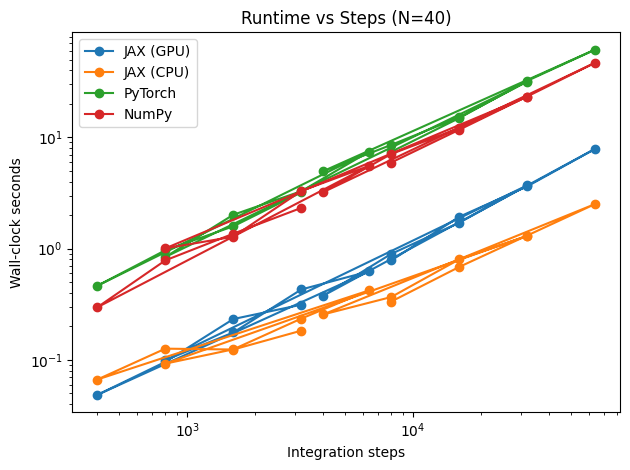

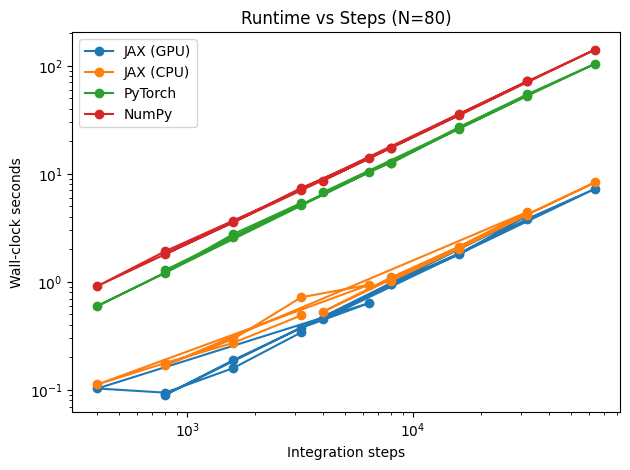

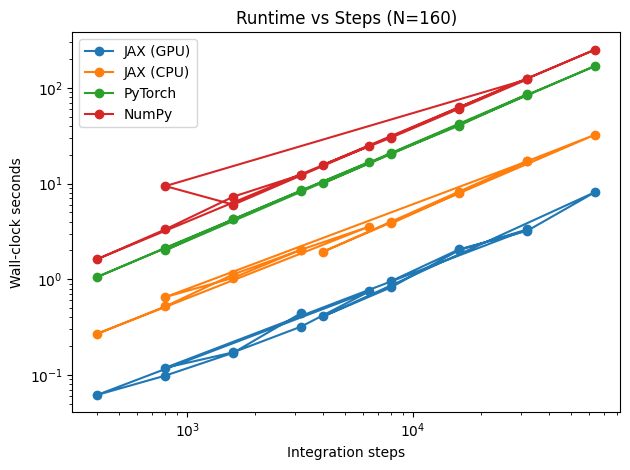

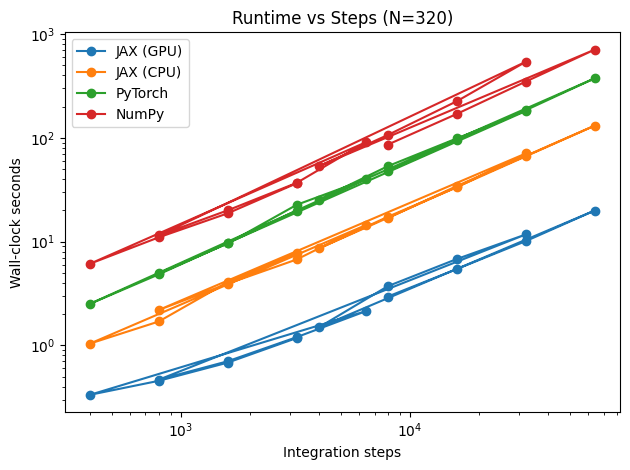

In [25]:
# 2) Runtime vs Steps (log–log), one figure per N
for N_val, group in df.groupby('N'):
    fig, ax = plt.subplots()
    for col, label in [
        ('jax_gpu',   'JAX (GPU)'),
        ('jax_cpu',   'JAX (CPU)'),
        ('torch_time','PyTorch'),
        ('numpy_time','NumPy'),
    ]:
        ax.plot(group['steps'], group[col], marker='o', label=label)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f'Runtime vs Steps (N={N_val})')
    ax.set_xlabel('Integration steps')
    ax.set_ylabel('Wall-clock seconds')
    ax.legend()
    plt.tight_layout()
    plt.show()

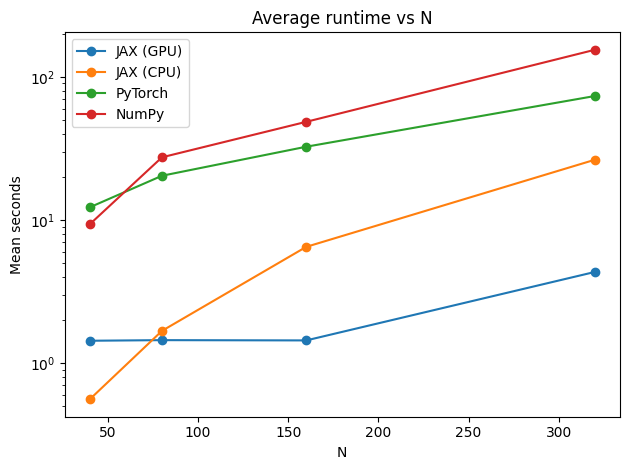

In [26]:

# 3) Average runtime vs N (log-y)
mean_rt = df.groupby('N')[['jax_gpu','jax_cpu','torch_time','numpy_time']].mean()

fig, ax = plt.subplots()
for col, label in [
    ('jax_gpu',   'JAX (GPU)'),
    ('jax_cpu',   'JAX (CPU)'),
    ('torch_time','PyTorch'),
    ('numpy_time','NumPy'),
]:
    ax.plot(mean_rt.index, mean_rt[col], marker='o', label=label)
ax.set_yscale('log')
ax.set_title('Average runtime vs N')
ax.set_xlabel('N')
ax.set_ylabel('Mean seconds')
ax.legend()
plt.tight_layout()
plt.show()

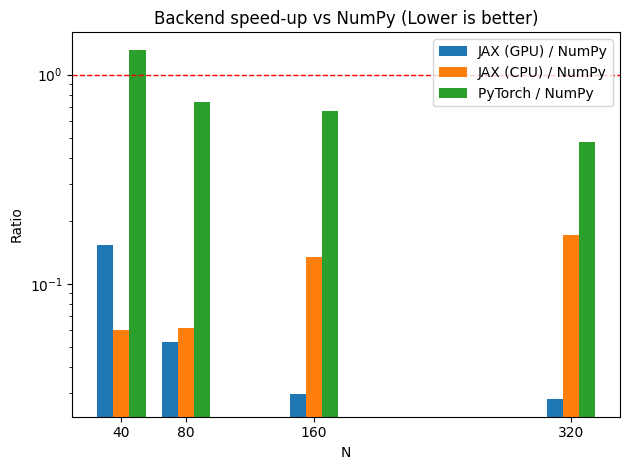

In [27]:
# 4) Backend speed-up vs NumPy (bar chart, log-y)
# sum runtimes across dt & simtime for each N, then ratio
sum_per_N = df.groupby('N')[['jax_gpu','jax_cpu','torch_time','numpy_time']].sum()
ratio = pd.DataFrame({
    'JAX (GPU) / NumPy':  sum_per_N['jax_gpu']   / sum_per_N['numpy_time'],
    'JAX (CPU) / NumPy':  sum_per_N['jax_cpu']   / sum_per_N['numpy_time'],
    'PyTorch    / NumPy': sum_per_N['torch_time']/ sum_per_N['numpy_time'],
})

fig, ax = plt.subplots()
width = 10
x = ratio.index.values
ax.bar(x - width, ratio['JAX (GPU) / NumPy'], width, label='JAX (GPU) / NumPy')
ax.bar(x          , ratio['JAX (CPU) / NumPy'], width, label='JAX (CPU) / NumPy')
ax.bar(x + width, ratio['PyTorch    / NumPy'], width, label='PyTorch / NumPy')
ax.set_yscale('log')
ax.axhline(1, color='red', linestyle='--', linewidth=1)
ax.set_title('Backend speed-up vs NumPy (Lower is better)')
ax.set_xlabel('N')
ax.set_ylabel('Ratio')
ax.set_xticks(x)
ax.legend()
plt.tight_layout()
plt.show()

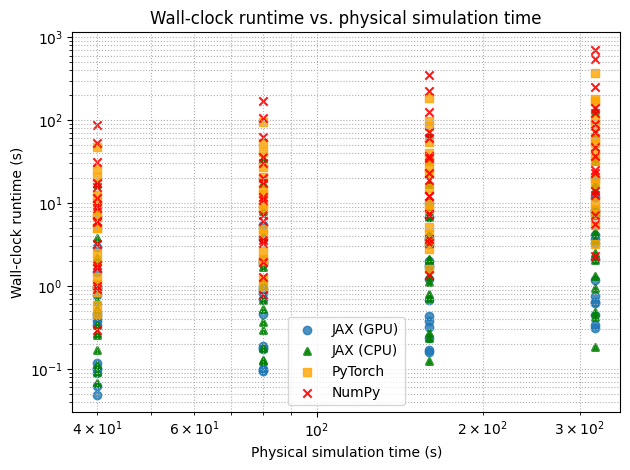

In [28]:
# 5) Scatter: wall-clock runtime vs physical simtime (log–log)
fig, ax = plt.subplots()

# JAX GPU (default color)
ax.scatter(
    df['simtime'], df['jax_gpu'],
    label='JAX (GPU)',
    marker='o',
    alpha=0.8
)

# JAX CPU — red ×’s, a bit bolder
ax.scatter(
    df['simtime'], df['jax_cpu'],
    label='JAX (CPU)',
    marker='^',
    color='green',
    alpha=0.8,
    linewidths=2,
    s=20
)

# PyTorch (default color)
ax.scatter(
    df['simtime'], df['torch_time'],
    label='PyTorch',
    marker='s',
    color='orange',
    alpha=0.8
)

# NumPy — orange triangles
ax.scatter(
    df['simtime'], df['numpy_time'],
    label='NumPy',
    marker='x',
    color='red',
    alpha=0.9
)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Physical simulation time (s)')
ax.set_ylabel('Wall-clock runtime (s)')
ax.set_title('Wall-clock runtime vs. physical simulation time')
ax.grid(True, which='both', ls=':')
ax.legend()
plt.tight_layout()
plt.show()
